<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
#!pip install datasets

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\STEPANJUK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [5]:
# Список всех предложений из тренировочного датасета.
sentences = []
# Ограничение по длинне предложения.
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['test']['text']):
    sentences.extend(
        # Функция sent_tokenize используется для разбиения текста на отдельные предложения.
        # Функция word_tokenize используется для разбиения текста на отдельные слова и знаки препинания.
        [x.lower() for x in sent_tokenize(sentence, language='english') if len(word_tokenize(x)) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [6]:
print("Всего предложений:", len(sentences))

Всего предложений: 195564


Посчитаем для каждого слова его встречаемость.

In [7]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for w in word_tokenize(sentence):
        words[w] += 1

  0%|          | 0/195564 [00:00<?, ?it/s]

In [8]:
# Выведим кол-во слов в датасете.
len_words = len(words)
print("Amount of words: ", len_words)

# Преобразуем Counter() в список.
words = list(words.items())
# Отсортируем список слов в датасете по частоте вхождения в датасет.
words = sorted(words, key=lambda x: x[1], reverse=True)

# Выведим первые 5 слов и их частоту вхождения в датасет.
print("Top:", words[0 : 5])
# Выведим последние 5 слов и их частоту вхождения в датасет.
print("Bottom:", words[len_words-5 : -1])

Amount of words:  67183
Top: [('.', 167041), ('the', 150255), (',', 111356), ('a', 74215), ('and', 71704)]
Bottom: [('stress-related', 1), ('nose-bleed', 1), ('b-list', 1), ('whorish', 1)]


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [9]:
# Cловарь
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
# Размер словаря
vocab_size = 40000

# Наполнение словаря
for w, cnt in words:
    vocab.add(w)
    # Если словарь полон, то выходим из цикла.
    if  len(vocab) >= vocab_size + 4:
        break

In [10]:
# assert - Проверка условий, если условие ложно, assert вызывает ошибку AssertionError и прерывает выполнение кода.
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [11]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [12]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [13]:
class WordDataset:
    def __init__(self, sentences):
        # Список предложений из тренировочного датасета.
        self.data = sentences
        #'<unk>'- неизвестные слова 
        self.unk_id = word2ind['<unk>']
        #'<bos>' - начало последовательности
        self.bos_id = word2ind['<bos>']
        #'<eos>' - конец последовательности
        self.eos_id = word2ind['<eos>']
        #'<pad>' - для обьеденения последовательностей
        self.pad_id = word2ind['<pad>']

    # Преобразуем предложение из датасета состоящие из слов в список индексов из словаря.
    def __getitem__(self, idx: int) -> List[int]:
        # Добавляем ID токена '<bos>' - начало последовательности
        tokenized_sentence = [self.bos_id]
        # Для каждого слова из предложения добавляем его ID из словаря в последовательность.
        # Для неизвестных слов добавляем ID токена '<unk>'- неизвестные слова 
        #tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        # Добавляем ID токена '<eos>' - конец последовательности
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [14]:
# Собираем последовательности(предложения) разных длин в один бач.
# Функция принимает на вход батч из датадлоадера и токен для обьеденения последовательностей  и заполнения пустоты.
def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:

    # Длинны всех последовательностей(предложений) в баче.
    seq_lens = [len(x) for x in input_batch]
    # Максимальная длинна последовательности.
    max_seq_len = max(seq_lens)

    # Формирируем новый батч последовательностей.
    new_batch = []
    # Проходи через каждое предложение в батче.
    for sequence in input_batch:
        # Добавить pad_id для заполнения пустоты чтобы все последовательности были одной длинны. 
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        # Добавляем к новому батчу последовательность приведённую к нужной длинне с pad_id по краям.
        new_batch.append(sequence)

    # Конвертируем последовательность в тензор и загружаем на девайс.
    sequences = torch.LongTensor(new_batch).to(device)

    
    new_batch = {
        # Последовательность токенов от первого до предпоследнего.
        'input_ids': sequences[:,:-1],
        # Последовательность токенов от второго до последнего.
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [15]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [16]:
# Расчёт перплексии
def evaluate(model, criterion, dataloader) -> float:
    # Переводим модель в режим для оценки предсказаний
    model.eval()
    # Список для перплексии с каждого бача.
    perplexity = []
    # Без расчёта производных.
    with torch.no_grad():
        # Пройти через все батчи.
        for batch in tqdm(dataloader, desc=f'Validation:'):
        #for batch in dataloader:
            # Посчитать логиты предсказаний следующих слов
            logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1)
            # Расчитать функцию потерь "CrossEntropyLoss" - логарифм от предсказанной вероятности для нужного слова.
            loss = criterion(logits, batch['target_ids'].to(device).flatten())
            # Добавить в списиок перплексии экспоненты от логарифмов предсказанных вероятностей нужных слов.
            perplexity.append(torch.exp(loss).item())

    # Перплексия равна среднеарифметическому значению от всех экспонент.
    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [17]:
def train_model(
        model: nn.Module,         # Модель
        criterion: nn.Module,     # Функция потерь
        optimizer: torch.optim.Optimizer, # оптимизатор 
        num_epochs: int,          # Кол-во эпох
        train_loader: DataLoader, # Тренировочные данные
        val_loader: DataLoader    # Валидационные данные
        ) -> [List[float], List[float]]:
    
    # Список CrossEntropyLoss для всех эпох
    losses = []
    # Список перплексии для всех эпох
    perplexities = []

    # Пройдём по всем эпохам.
    for epoch in range(num_epochs):
        # Список CrossEntropyLoss для текущей эпохи
        epoch_losses = []
        # Переводим модель в режим для обучения
        model.train()
        # Пройдём по всем бачам в даталоадере.
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            # Обнулим производные.
            optimizer.zero_grad()
            
            # Посчитать логиты предсказаний следующих слов
            #logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            logits = model(batch['input_ids'].to(device)).flatten(start_dim=0, end_dim=1)
            # Расчитать функцию потерь "CrossEntropyLoss"
            loss = criterion(logits, batch['target_ids'].to(device).flatten())
            # Расчитать производные
            loss.backward()
            # Сделать шаг обучения
            optimizer.step()
            # Сохранить значения функции потерь "CrossEntropyLoss"  для текущей эпохи.
            #epoch_losses.append(loss.item())
            epoch_losses.append(loss.detach().cpu().numpy())

        # Сохранить значения функции потерь "CrossEntropyLoss"
        losses.append(sum(epoch_losses) / len(epoch_losses))
        # Расчитать и сохранить перплексию
        perplexities.append(evaluate(model, criterion, val_loader))

    return losses, perplexities

## Generation

In [37]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [word2ind.get(char, word2ind['<unk>']) for char in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [19]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [20]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [21]:
history = train_model(
        model=model,         # Модель
        criterion=criterion,     # Функция потерь
        optimizer=optimizer, # оптимизатор 
        num_epochs=5,          # Кол-во эпох
        train_loader=train_dataloader, # Тренировочные данные
        val_loader=eval_dataloader    # Валидационные данные
        )

Training epoch 0::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

In [38]:
generate_sequence(model, starting_seq='it is')

'<bos> it is a shame that it is a good movie . <eos>'

In [23]:
losses, perplexities = history

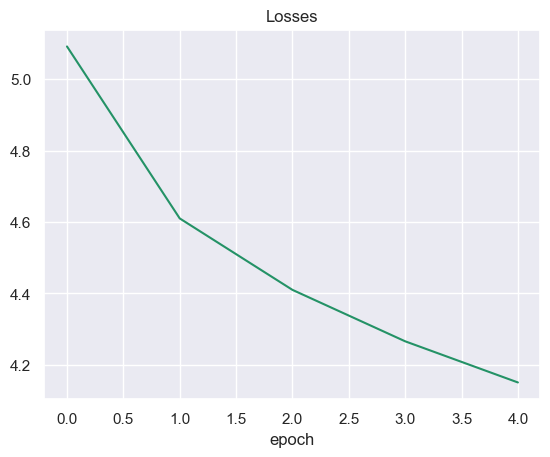

In [24]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

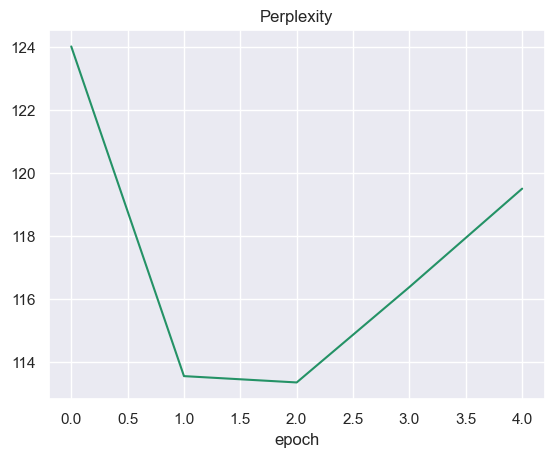

In [25]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [26]:
perp = evaluate(model=model.to(device), criterion=criterion, dataloader=test_dataloader)
print(perp)

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

117.36578109217625


In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [27]:
class LanguageModelLSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [28]:
modelLSTM = LanguageModelLSTM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterionLSTM = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizerLSTM = torch.optim.Adam(modelLSTM.parameters())

In [29]:
historyLSTM = train_model(
                            model=modelLSTM,         # Модель
                            criterion=criterionLSTM,     # Функция потерь
                            optimizer=optimizerLSTM, # оптимизатор 
                            num_epochs=5,          # Кол-во эпох
                            train_loader=train_dataloader, # Тренировочные данные
                            val_loader=eval_dataloader    # Валидационные данные
                            )

Training epoch 0::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4890 [00:00<?, ?it/s]

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

In [39]:
generate_sequence(modelLSTM, starting_seq='it is')

"<bos> it is a very good movie , but it 's not . <eos>"

In [31]:
lossesLSTM, perplexitiesLSTM = historyLSTM

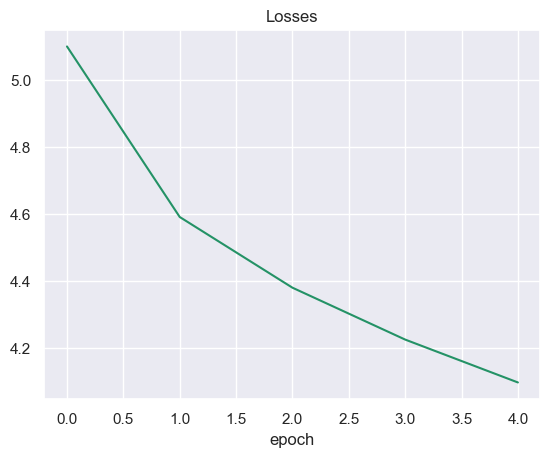

In [32]:
plt.plot(np.arange(len(lossesLSTM)), lossesLSTM)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

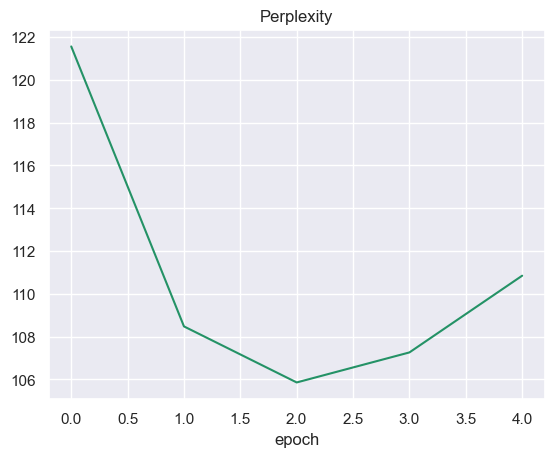

In [33]:
plt.plot(np.arange(len(perplexitiesLSTM)), perplexitiesLSTM)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [34]:
perpLSTM = evaluate(model=modelLSTM.to(device), criterion=criterion, dataloader=test_dataloader)
print(perpLSTM)

Validation::   0%|          | 0/612 [00:00<?, ?it/s]

108.89416297588473


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Было проведено 2 эксперимента, на одном наборе данных были обучены GRU и LSTM при прочих равных условиях.

LSTM показала более низкое значении перплексии 108.89, чем GRU 117.36.

Обе модели начали переобучаться начиная с 3-4 эпохи.

Чтобы побороть проблему переобучения следует попробовать увеличить размерность скрытого слоя, увеличить кол-во рекуррентных слоёв, увеличить dropout и увеличить размер датасета, а также видимо механизм атеншн должен помочь побороть эту проблему.